# ONLINE PAYMENT FRAUD DETECTION

In [1]:
# Import the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, cohen_kappa_score, 
                            classification_report)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score, train_test_split)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# load the dataset
data = pd.read_csv('Dataset.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
# Let's check for missing values
data.isnull().sum()

# No missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
# Let's check for duplicate values
data.duplicated().sum()

# No duplicate Values

np.int64(0)

In [7]:
# The columns 'nameOrig' and 'nameDest' are not of much significance, let's drop these columns
data.drop(columns = ['nameOrig', 'nameDest'], inplace=True)

## Feature Engineering

In [8]:
# Let's perform some feature engineering and create relevant features; also delete the features which are not required)

In [9]:
data['day'] = ((data['step'] - 1) // 24) + 1
data['hour_of_day'] = (data['step'] - 1) % 24

In [10]:
def time_segment(hour):
    if 0 <= hour <= 5:
        return 'Mid_Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:
        return 'Night'

data['time_segment'] = data['hour_of_day'].apply(time_segment)

In [11]:
data['time_segment'].value_counts()

time_segment
Afternoon    2786875
Morning      1674560
Evening      1643903
Night         212844
Mid_Night      44438
Name: count, dtype: int64

## Feature Encoding

In [12]:
# Performing Label encoding for categorical column 'time_segment'
data['time_segment'] = data['time_segment'].map({'Afternoon':2, 'Morning':1, 'Evening':3, 'Night':4, 'Mid_Night':0})

In [13]:
data.drop(columns='step', inplace=True)

In [14]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [15]:
# Performing One-Hot encoding for categorical column 'type'
data = pd.get_dummies(data=data, dtype=int)

In [16]:
data.drop(columns='hour_of_day', inplace=True)

In [17]:
data = data[['day', 'time_segment', 'type_CASH_IN','type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER','amount', 'oldbalanceOrg', 
             'newbalanceOrig', 'oldbalanceDest','newbalanceDest', 'isFraud']]

In [18]:
data.head()

,day,time_segment,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,0,0,0,0,1,0,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,0,0,0,0,1,0,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,0,0,0,0,0,1,181.00,181.0,0.00,0.0,0.0,1
3,1,0,0,1,0,0,0,181.00,181.0,0.00,21182.0,0.0,1
4,1,0,0,0,0,1,0,11668.14,41554.0,29885.86,0.0,0.0,0


## Train-Test Split

In [19]:
x = data.drop(columns='isFraud')
y = data['isFraud']

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7,stratify=y, random_state=2)

In [20]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4453834, 12) (4453834,)
(1908786, 12) (1908786,)


## Modular Coding (creating functions for tasks)

In [21]:
def model_train(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]

    return m, pred_h, pred_s

In [22]:
def model_score(predh,preds,ytest=y_test):
    print('Classification Report')
    print(classification_report(ytest,predh))

    fpr, tpr, thres = roc_curve(ytest,preds)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1], color='red', ls = '--')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,preds),4)}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [23]:
def model_tuning(model,grid,x=x_train,y=y_train,folds=6,score='roc_auc'):

    gscv = GridSearchCV(estimator=model, param_grid=grid, scoring=score, cv=folds, verbose=1, n_jobs=-1)
    gscv.fit(x,y)
    print('Best Score', gscv.best_score_)
    return gscv.best_params_

In [24]:
mod = []
accu = []
rec = []
prec = []
f1 = []
ck = []
auc = []

def model_name(model):
    return str(model).split('(')[0]
    
def model_scorecard(model,predh,preds,ytest=y_test):
    mod.append(model_name(model))
    accu.append(accuracy_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    prec.append(precision_score(ytest,predh))
    f1.append(f1_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))

    scorecard = pd.DataFrame({'Accuracy':accu,'Precision':prec,'Recall':rec,'F1':f1,'Cohen Kappa':ck,'ROC AUC':auc},index=mod)
    return scorecard

## Logistic Regression

In [25]:
model_lr, predh_lr, preds_lr = model_train(LogisticRegression(),
                                          x_train, y_train, x_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.44      0.40      0.42      2464

    accuracy                           1.00   1908786
   macro avg       0.72      0.70      0.71   1908786
weighted avg       1.00      1.00      1.00   1908786



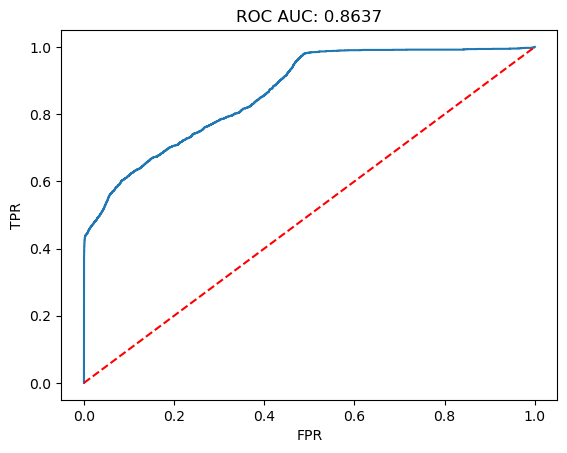

In [26]:
model_score(predh_lr, preds_lr)

In [27]:
model_scorecard(model_lr,predh_lr,preds_lr)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.42103,0.420322,0.863678


## Naive Bayes'

In [28]:
model_gnb, predh_gnb, preds_gnb = model_train(GaussianNB(),
                                          x_train, y_train, x_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.03      0.16      0.05      2464

    accuracy                           0.99   1908786
   macro avg       0.51      0.58      0.52   1908786
weighted avg       1.00      0.99      0.99   1908786



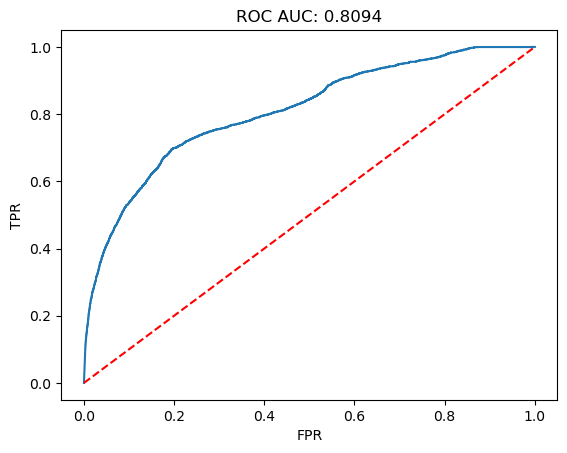

In [29]:
model_score(predh_gnb, preds_gnb)

In [30]:
model_scorecard(model_gnb,predh_gnb,preds_gnb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429


In [31]:
model_mnb, predh_mnb, preds_mnb = model_train(MultinomialNB(),
                                          x_train, y_train, x_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.63      0.77   1906322
           1       0.00      0.86      0.01      2464

    accuracy                           0.63   1908786
   macro avg       0.50      0.74      0.39   1908786
weighted avg       1.00      0.63      0.77   1908786



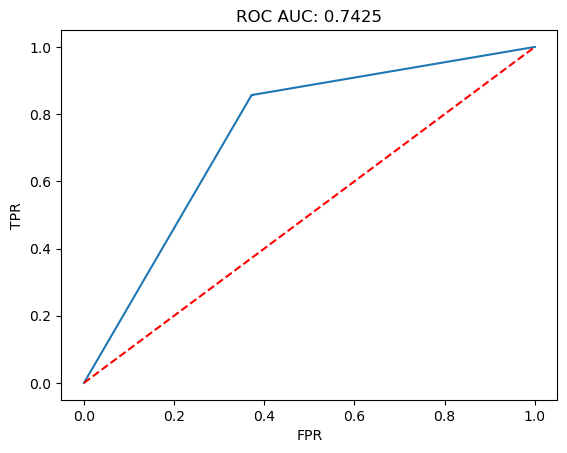

In [32]:
model_score(predh_mnb, preds_mnb)

In [33]:
model_scorecard(model_mnb,predh_mnb,preds_mnb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458


## K-Nearest Neighbors

In [34]:
tuned_params = model_tuning(KNeighborsClassifier(),
            {'n_neighbors':[40,50,60]})

Fitting 6 folds for each of 3 candidates, totalling 18 fits
Best Score 0.9628236409904326


In [35]:
tuned_params

{'n_neighbors': 60}

In [36]:
model_knn, predh_knn, preds_knn = model_train(KNeighborsClassifier(**tuned_params, n_jobs=-1),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.89      0.58      0.70      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.79      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



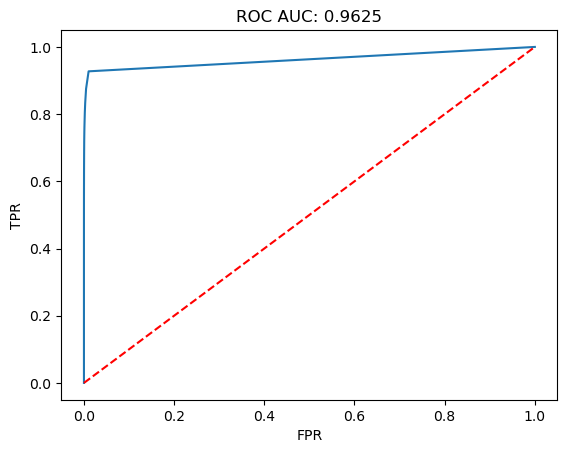

In [37]:
model_score(predh_knn, preds_knn)

In [38]:
model_scorecard(model_knn,predh_knn, preds_knn)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543


## Decision Tree

In [39]:
tuned_params = model_tuning(DecisionTreeClassifier(),
            {'max_depth':[5,7,9,11], 'max_leaf_nodes':[15,20,25]})

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Score 0.9152176713225993


In [40]:
tuned_params

{'max_depth': 7, 'max_leaf_nodes': 25}

In [41]:
model_dt, predh_dt, preds_dt = model_train(DecisionTreeClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.82      0.72      0.76      2464

    accuracy                           1.00   1908786
   macro avg       0.91      0.86      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



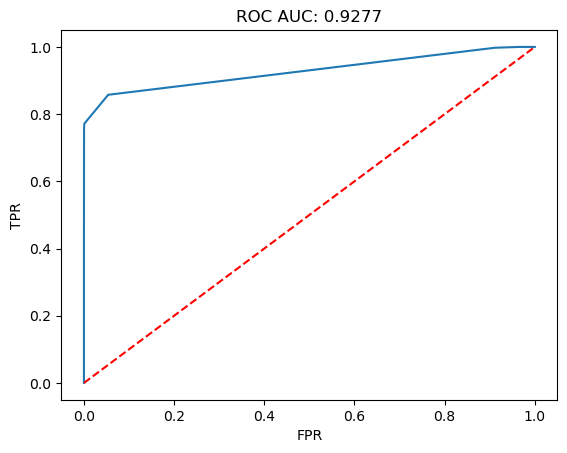

In [42]:
model_score(predh_dt, preds_dt)

In [43]:
model_scorecard(model_dt,predh_dt, preds_dt)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740


## Random Forest

In [44]:
tuned_params=model_tuning(RandomForestClassifier(),
                   grid={'n_estimators':[50,70,90],'max_depth':[6,7,8]})

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Best Score 0.994225832552256


In [45]:
tuned_params

{'max_depth': 8, 'n_estimators': 70}

In [46]:
model_rf, predh_rf, preds_rf = model_train(RandomForestClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.65      0.79      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.82      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786



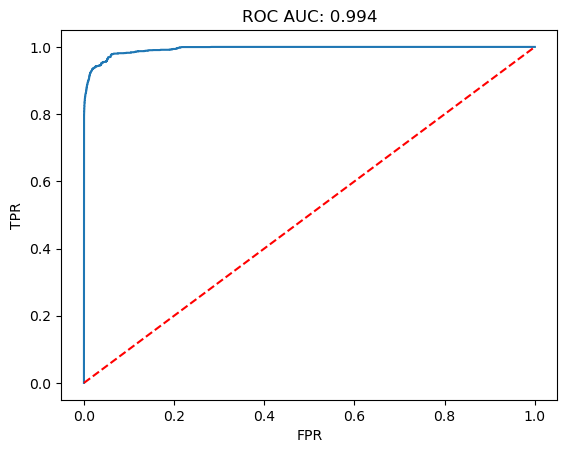

In [47]:
model_score(predh_rf, preds_rf)

In [48]:
model_scorecard(model_rf,predh_rf, preds_rf)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740
RandomForestClassifier,0.999546,0.999375,0.648945,0.786909,0.786693,0.994028


## Adaptive Boosting

In [51]:
tuned_params=model_tuning(AdaBoostClassifier(),
                   grid={'n_estimators': [50,60,70]})

Fitting 6 folds for each of 3 candidates, totalling 18 fits
Best Score 0.9966477163721551


In [52]:
tuned_params

{'n_estimators': 70}

In [53]:
model_ada, predh_ada, preds_ada = model_train(AdaBoostClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.47      0.64      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.74      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



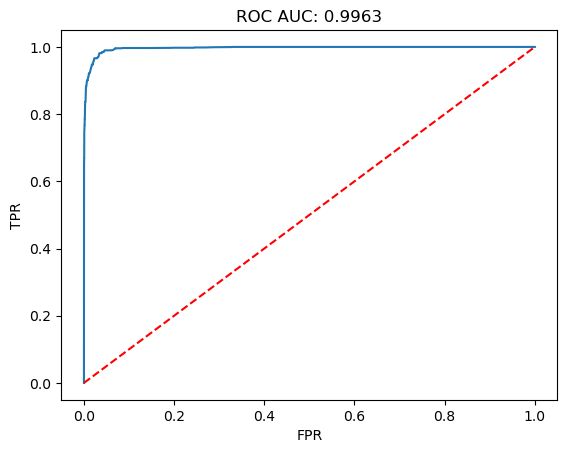

In [54]:
model_score(predh_ada, preds_ada)

In [55]:
model_scorecard(model_ada,predh_ada, preds_ada)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740
RandomForestClassifier,0.999546,0.999375,0.648945,0.786909,0.786693,0.994028
AdaBoostClassifier,0.999308,0.984733,0.471185,0.637387,0.637084,0.996337


## Gradient Boosting

In [66]:
tuned_params = model_tuning(GradientBoostingClassifier(random_state=2), grid = {'n_estimators':[80,90],
                                                                                'max_depth':[7,8]})

Fitting 6 folds for each of 4 candidates, totalling 24 fits
Best Score 0.8096920044301129


In [67]:
tuned_params

{'max_depth': 8, 'n_estimators': 90}

In [68]:
model_gb, predh_gb, preds_gb = model_train(GradientBoostingClassifier(random_state=2,**tuned_params),
                                              x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.84      0.51      0.63      2464

    accuracy                           1.00   1908786
   macro avg       0.92      0.75      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



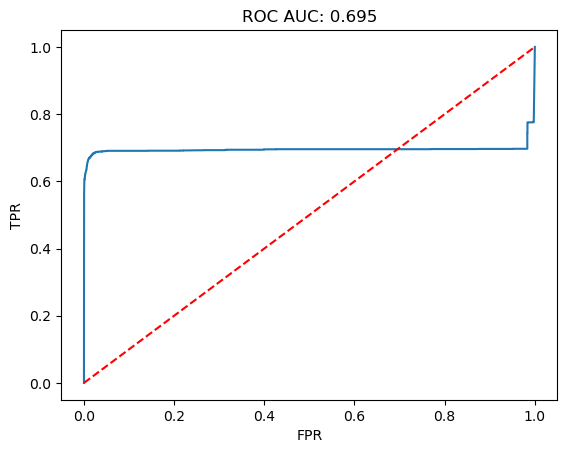

In [69]:
model_score(predh_gb, preds_gb)

In [70]:
model_scorecard(model_gb,predh_gb, preds_gb)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740
RandomForestClassifier,0.999546,0.999375,0.648945,0.786909,0.786693,0.994028
AdaBoostClassifier,0.999308,0.984733,0.471185,0.637387,0.637084,0.996337
GradientBoostingClassifier,0.999238,0.835662,0.509740,0.633224,0.632865,0.695013


## Light GBM

In [62]:
tuned_params = model_tuning(LGBMClassifier(random_state=2), grid = {'n_estimators':[60,80,100],
                                                                                'max_depth':[7,8]})

Fitting 6 folds for each of 6 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
Best Score 0.8569981528810029


In [63]:
tuned_params

{'max_depth': 7, 'n_estimators': 60}

In [64]:
model_lgbm, predh_lgbm, preds_lgbm = model_train(LGBMClassifier(random_state=2,**tuned_params),
                                              x_train,y_train,x_test,y_test)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.60      0.74      0.66      2464

    accuracy                           1.00   1908786
   macro avg       0.80      0.87      0.83   1908786
weighted avg       1.00      1.00      1.00   1908786



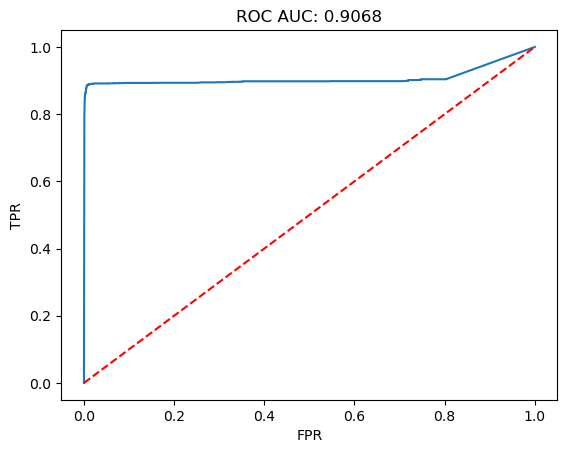

In [65]:
model_score(predh_lgbm, preds_lgbm)

In [71]:
model_scorecard(model_lgbm,predh_lgbm, preds_lgbm)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740
RandomForestClassifier,0.999546,0.999375,0.648945,0.786909,0.786693,0.994028
AdaBoostClassifier,0.999308,0.984733,0.471185,0.637387,0.637084,0.996337
GradientBoostingClassifier,0.999238,0.835662,0.509740,0.633224,0.632865,0.695013
LGBMClassifier,0.999018,0.597167,0.735795,0.659273,0.658786,0.906800


## XG Boost

In [57]:
tuned_params=model_tuning(XGBClassifier(),
                   grid={'max_depth': [7,9], 'n_estimators': [80,90], 'reg_lambda': [2,3,4]})

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Score 0.9972394627000932


In [58]:
tuned_params

{'max_depth': 9, 'n_estimators': 90, 'reg_lambda': 3}

In [59]:
model_xgb, predh_xgb, preds_xgb = model_train(XGBClassifier(**tuned_params),
                                          x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.95      0.85      0.90      2464

    accuracy                           1.00   1908786
   macro avg       0.97      0.93      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



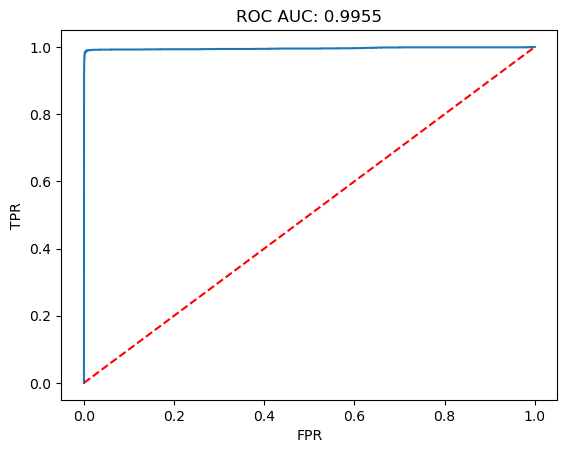

In [60]:
model_score(predh_xgb, preds_xgb)

In [72]:
scorecard = model_scorecard(model_xgb,predh_xgb, preds_xgb)

In [75]:
scorecard.sort_values(by='Cohen Kappa', ascending=False)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
XGBClassifier,0.999750,0.947321,0.853896,0.898186,0.898061,0.995535
RandomForestClassifier,0.999546,0.999375,0.648945,0.786909,0.786693,0.994028
DecisionTreeClassifier,0.999426,0.817633,0.715097,0.762936,0.762650,0.927740
KNeighborsClassifier,0.999361,0.886816,0.578734,0.700393,0.700087,0.962543
LGBMClassifier,0.999018,0.597167,0.735795,0.659273,0.658786,0.906800
AdaBoostClassifier,0.999308,0.984733,0.471185,0.637387,0.637084,0.996337
GradientBoostingClassifier,0.999238,0.835662,0.509740,0.633224,0.632865,0.695013
LogisticRegression,0.998581,0.444695,0.399756,0.421030,0.420322,0.863678
GaussianNB,0.991956,0.029493,0.163961,0.049994,0.047911,0.809429
MultinomialNB,0.628481,0.002968,0.856331,0.005916,0.003351,0.742458


## Final Model

In [77]:
# Validating the final model 
scores = cross_val_score(estimator=model_xgb, cv=KFold(n_splits=7,shuffle=True, random_state=2),
                        scoring='roc_auc',X=x, y=y, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  3.6min finished


In [80]:
scores

array([0.99551644, 0.99726225, 0.99811344, 0.99799022, 0.9944706 ,
       0.99319847, 0.99520927])

In [83]:
print('Average score:', scores.mean())
print('sd of score:', scores.std())

Average score: 0.9959658126977863
sd of score: 0.0017344974501471641


## Creating a Joblib File

In [84]:
import joblib

In [86]:
# creating some files that we need for deployment
with open('final_model.joblib', 'wb') as file:
    joblib.dump(model_xgb, file)